In [1]:
import os
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.spatial.distance as ssd
from random import randint
from random import shuffle
import glob
import plotly.plotly as py
import pylab as P
import math

# https://github.com/hammerlab/fancyimpute

from fancyimpute import KNN

%matplotlib inline 



# other datas
path = './datas/'

# Reading file

from numpy import genfromtxt
records_matrix_personal = genfromtxt(path + 'Skipogh Steroids_cat2VClear.csv', delimiter=';')
records_matrix_personal = records_matrix_personal[1::]

participant_ids = records_matrix_personal[:,0]
participant_ids = np.array(participant_ids)
#print participant_ids

headers_personal = ["id","waistc1","bw","bia_fmkg","hipcirc1","armcicrc1_l",
                    "skinf2_1","bsa_dubois","bia_fmp","kid_vol","crap","ura",
                    "dbp5","sbp","cuff_sh","ud_mlkg","ckd_epi","sex","crp","bmi"]

#print headers_personal
#print records_matrix_personal



records_matrix_steroid = genfromtxt(path + 'Skipogh Steroids_original.csv', delimiter=';')
records_matrix_steroid = records_matrix_steroid[1::]

headers_steroid = ["id","ccr_andro_d","ccr_etio_d","ccr_s_ad_17b_d","ccr_s_at_d",
                   "ccr_sa_dihydrotest_d","ccr_saad3a17b_d","ccr_testosterone_d",
                   "ccr_estriol_d","ccr_l7b_estradiol_d","ccr_dha_d",
                   "ccr_l6a_oh_dha_d","ccr_s_pt_d","ccr_tha_d","ccr_thb_d",
                   "ccr_sa_thb_d","ccr_thaldo_d","ccr_thdoc_d","ccr_l8_oh_tha_d",
                   "ccr_pd_d","ccr_pt_d","ccr_pt_one_d","ccr_ths_d","ccr_cortisol_d",
                   "cr_l8_oh_f_d","ccr_thf_d","ccr_sa_thf_d","ccr_a_cortol_d",
                   "ccr_b_cortol_d","ccr_llb_oh_andro_d","ccr_llb_oh_etio_d",
                   "ccr_cortisone_d","ccr_the_d","ccr_a_cortolone_d","ccr_b_cortolone_d",
                   "ccr_ll_oxo_etio_d","ccr_sb_oh_f_d","ccr_zoa_dhe_d","ccr_zoa_dhf_d",
                   "ccr_zob_dhe_d","ccr_zob_dhf_d","bmi"]

#print headers_steroid
#print records_matrix_steroid

mask = [idx in participant_ids for idx in records_matrix_steroid[:,0]]

records_matrix_steroid = records_matrix_steroid[mask]

# les participants sont les mêmes dans les 2 sets

# records_matrix_steroid => dataset steroid 
# records_matrix_personal -> dataset others

matrice_names = [headers_steroid] + records_matrix_steroid.tolist()

matrice_names = np.array(matrice_names)
print matrice_names


[['id' 'ccr_andro_d' 'ccr_etio_d' ..., 'ccr_zob_dhe_d' 'ccr_zob_dhf_d'
  'bmi']
 ['2.0' '120.6260829' '137.4930833' ..., '1.466035299' 'nan' '26.31862079']
 ['5.0' '755.2787141' '814.26646' ..., '21.06796794' 'nan' '26.68809407']
 ..., 
 ['1126.0' 'nan' '60.53009286' ..., '6.214831155' '9.982483986'
  '24.5775163']
 ['1127.0' '108.5834786' '165.7337127' ..., '7.050261907' '30.66490588'
  '24.01241807']
 ['1128.0' '181.5327551' '108.4946127' ..., '11.74202216' '9.179348582'
  '30.80073749']]


In [2]:
def missing_steroid(matrice):
    matrice = np.array(matrice)
    bySteroid = matrice.transpose()

    missingSteroid = []

    for line in bySteroid[1:-1]:
        compteur = 0
        for elem in line[1:]:
            elem = float(elem)
            if math.isnan(elem):
                compteur += 1
        tab = [line[0], compteur]
        missingSteroid.append(tab)

    #print np.array(missingSteroid)
    #[l.strip().split(';') for l in records_matrix.readlines()[0::]]
    tmp = np.array(missingSteroid).transpose()
    
    print("Steroïds and number missing")
    names = tmp[0]
    print names
    
    values = [int(l) for l in tmp[1]]
    print values
    
    y_values = values
    text_values = names
    x_values = np.arange(1, len(text_values) + 1, 1)

    plt.figure(figsize=(15,15), dpi=300)
    plt.bar(x_values, y_values)
    # Decide which ticks to replace.
    #new_ticks = [str(y) for y in y_values]

    plt.yticks()
    plt.xticks(x_values, text_values,  rotation='vertical')
    plt.title("Missing Steroid in dataset")
    plt.grid()
    plt.show()

In [3]:
# Calculate the number of case where the steroid S is missing. 
#missing_steroid(matrice_names)

In [4]:
# source: panda dealing with misisng values https://chrisalbon.com/python/pandas_missing_data.html
raw_data = records_matrix_steroid

print type(raw_data)
print type(headers_steroid)
df = pd.DataFrame(raw_data, columns = headers_steroid)
df

<type 'numpy.ndarray'>
<type 'list'>


,id,ccr_andro_d,ccr_etio_d,ccr_s_ad_17b_d,ccr_s_at_d,ccr_sa_dihydrotest_d,ccr_saad3a17b_d,ccr_testosterone_d,ccr_estriol_d,ccr_l7b_estradiol_d,...,ccr_the_d,ccr_a_cortolone_d,ccr_b_cortolone_d,ccr_ll_oxo_etio_d,ccr_sb_oh_f_d,ccr_zoa_dhe_d,ccr_zoa_dhf_d,ccr_zob_dhe_d,ccr_zob_dhf_d,bmi
0,2.0,120.626083,137.493083,3.037205,26.308033,0.530343,3.898135,5.310435,1.711348,1.124934,...,81.768553,25.507846,31.534362,12.242271,3.330412,0.626131,1.490567,1.466035,NaN,26.318621
1,5.0,755.278714,814.266460,113.202168,171.071973,19.499546,87.357231,28.045881,14.525829,4.460717,...,1686.292374,760.857429,439.290498,NaN,66.989809,9.388466,16.947413,21.067968,NaN,26.688094
2,6.0,141.205092,154.546512,20.441715,35.353462,1.970645,6.191817,13.467604,0.370500,0.215647,...,182.754958,64.020728,30.383263,40.213545,1.069058,1.262910,2.453556,3.160144,NaN,25.244705
3,8.0,20.221079,48.772655,1.248309,4.438712,0.339297,0.926736,1.212860,0.255739,0.081026,...,185.795414,71.882826,28.062888,30.283509,4.469096,0.906480,1.964883,2.463700,NaN,26.120668
4,9.0,119.543612,179.128214,8.963524,35.818154,1.512642,8.018498,9.513167,0.488239,0.265087,...,NaN,110.355432,54.263395,17.835690,3.837018,1.791207,3.661791,4.963261,NaN,24.648997
5,10.0,15.597018,34.396164,1.447697,2.058843,0.188224,0.794723,0.862112,0.123159,0.292793,...,158.628544,42.550205,29.778868,41.569582,3.469360,1.178142,1.666130,1.742813,NaN,19.571681
6,13.0,125.395243,113.701837,2.470737,16.562992,0.772105,2.076697,2.223131,0.191695,0.087860,...,201.048258,86.955043,34.286804,13.370736,3.852540,0.758793,4.084171,3.053810,NaN,22.935114
7,14.0,96.673896,128.082928,3.941372,9.312433,0.430723,1.886358,5.202404,0.199793,0.223146,...,225.929632,100.677547,53.326588,24.021874,5.853677,0.874419,2.955381,3.453566,NaN,23.199110
8,15.0,106.086506,54.923331,7.999913,33.339687,1.237266,5.017578,9.767148,0.298234,0.135011,...,204.132793,134.561762,50.772244,13.547460,3.042788,3.232207,6.968186,7.816540,NaN,26.536107
9,16.0,40.290484,76.382500,2.891891,10.391644,1.633221,1.925024,2.695904,0.217763,0.100171,...,230.083863,127.709206,55.904079,51.365902,2.277799,0.923314,2.430233,3.070456,NaN,27.057190


In [5]:
df_no_missing = df.dropna()
df_no_missing

,id,ccr_andro_d,ccr_etio_d,ccr_s_ad_17b_d,ccr_s_at_d,ccr_sa_dihydrotest_d,ccr_saad3a17b_d,ccr_testosterone_d,ccr_estriol_d,ccr_l7b_estradiol_d,...,ccr_the_d,ccr_a_cortolone_d,ccr_b_cortolone_d,ccr_ll_oxo_etio_d,ccr_sb_oh_f_d,ccr_zoa_dhe_d,ccr_zoa_dhf_d,ccr_zob_dhe_d,ccr_zob_dhf_d,bmi
21,36.0,84.416114,48.243316,3.238179,11.726936,1.697235,3.665717,5.404285,0.001292,0.173082,...,131.070696,78.806457,23.650205,14.507869,5.306119,1.619735,3.727717,5.049080,11.477647,29.258847
23,38.0,80.120022,57.712564,1.923184,6.091831,0.631454,4.378258,1.969037,0.222712,0.157209,...,152.483118,68.714543,33.953116,37.473276,3.471689,1.379505,3.412735,4.133274,8.432928,28.216135
26,42.0,129.330819,144.849578,7.188764,18.683089,0.732933,2.955158,2.630525,0.112115,0.092035,...,213.758642,82.779555,32.232302,6.419018,11.495998,1.547860,3.922361,4.524772,30.431765,17.477607
27,44.0,70.277286,49.324433,1.672430,6.498279,0.721350,2.176303,1.554502,0.147027,0.081171,...,226.523901,124.646577,27.415906,23.502850,5.032605,0.759639,3.024770,4.689543,12.583046,39.002083
28,46.0,84.922338,71.364746,3.285753,23.035907,0.650973,2.733376,3.544717,0.093845,0.086717,...,225.798697,120.641536,38.580867,16.078332,3.645689,1.414798,4.632840,7.386410,12.892363,35.382494
29,47.0,64.386086,120.380850,2.809237,9.793929,0.658857,3.015382,0.501216,0.206145,0.084883,...,293.955294,109.604697,44.713349,46.892023,7.437404,0.719488,1.535986,2.631386,35.457014,30.546874
32,50.0,279.872889,198.358846,7.240110,50.087823,2.402548,6.910315,5.186154,3.055302,0.251191,...,285.007788,139.212778,48.889965,31.458681,7.011133,2.332488,4.280499,8.923261,19.191333,25.279226
34,52.0,51.624176,23.574819,2.799843,10.591791,0.960521,2.626925,1.427162,0.549546,0.071062,...,184.846474,57.646681,36.315051,6.762734,7.155943,1.771813,2.469405,3.191868,13.476909,26.390541
35,54.0,75.510911,72.140036,1.879910,7.615675,0.669853,1.430940,1.025187,0.655447,0.242492,...,145.538144,69.427015,29.173415,19.843492,6.187136,1.318098,4.139163,3.589355,12.698394,17.527816
36,57.0,61.238981,129.573888,4.080014,21.214135,0.434168,1.980891,1.787066,1.128061,0.626054,...,259.403615,100.717236,41.883623,18.890175,8.260817,1.986705,4.989053,5.913598,20.467910,22.613575


In [6]:
df_cleaned = df.dropna(how='all')
df_cleaned

,id,ccr_andro_d,ccr_etio_d,ccr_s_ad_17b_d,ccr_s_at_d,ccr_sa_dihydrotest_d,ccr_saad3a17b_d,ccr_testosterone_d,ccr_estriol_d,ccr_l7b_estradiol_d,...,ccr_the_d,ccr_a_cortolone_d,ccr_b_cortolone_d,ccr_ll_oxo_etio_d,ccr_sb_oh_f_d,ccr_zoa_dhe_d,ccr_zoa_dhf_d,ccr_zob_dhe_d,ccr_zob_dhf_d,bmi
0,2.0,120.626083,137.493083,3.037205,26.308033,0.530343,3.898135,5.310435,1.711348,1.124934,...,81.768553,25.507846,31.534362,12.242271,3.330412,0.626131,1.490567,1.466035,NaN,26.318621
1,5.0,755.278714,814.266460,113.202168,171.071973,19.499546,87.357231,28.045881,14.525829,4.460717,...,1686.292374,760.857429,439.290498,NaN,66.989809,9.388466,16.947413,21.067968,NaN,26.688094
2,6.0,141.205092,154.546512,20.441715,35.353462,1.970645,6.191817,13.467604,0.370500,0.215647,...,182.754958,64.020728,30.383263,40.213545,1.069058,1.262910,2.453556,3.160144,NaN,25.244705
3,8.0,20.221079,48.772655,1.248309,4.438712,0.339297,0.926736,1.212860,0.255739,0.081026,...,185.795414,71.882826,28.062888,30.283509,4.469096,0.906480,1.964883,2.463700,NaN,26.120668
4,9.0,119.543612,179.128214,8.963524,35.818154,1.512642,8.018498,9.513167,0.488239,0.265087,...,NaN,110.355432,54.263395,17.835690,3.837018,1.791207,3.661791,4.963261,NaN,24.648997
5,10.0,15.597018,34.396164,1.447697,2.058843,0.188224,0.794723,0.862112,0.123159,0.292793,...,158.628544,42.550205,29.778868,41.569582,3.469360,1.178142,1.666130,1.742813,NaN,19.571681
6,13.0,125.395243,113.701837,2.470737,16.562992,0.772105,2.076697,2.223131,0.191695,0.087860,...,201.048258,86.955043,34.286804,13.370736,3.852540,0.758793,4.084171,3.053810,NaN,22.935114
7,14.0,96.673896,128.082928,3.941372,9.312433,0.430723,1.886358,5.202404,0.199793,0.223146,...,225.929632,100.677547,53.326588,24.021874,5.853677,0.874419,2.955381,3.453566,NaN,23.199110
8,15.0,106.086506,54.923331,7.999913,33.339687,1.237266,5.017578,9.767148,0.298234,0.135011,...,204.132793,134.561762,50.772244,13.547460,3.042788,3.232207,6.968186,7.816540,NaN,26.536107
9,16.0,40.290484,76.382500,2.891891,10.391644,1.633221,1.925024,2.695904,0.217763,0.100171,...,230.083863,127.709206,55.904079,51.365902,2.277799,0.923314,2.430233,3.070456,NaN,27.057190


In [7]:
# Drop rows that contain less than five observations

df_drop5 = df.dropna(thresh=5)
df_drop5

,id,ccr_andro_d,ccr_etio_d,ccr_s_ad_17b_d,ccr_s_at_d,ccr_sa_dihydrotest_d,ccr_saad3a17b_d,ccr_testosterone_d,ccr_estriol_d,ccr_l7b_estradiol_d,...,ccr_the_d,ccr_a_cortolone_d,ccr_b_cortolone_d,ccr_ll_oxo_etio_d,ccr_sb_oh_f_d,ccr_zoa_dhe_d,ccr_zoa_dhf_d,ccr_zob_dhe_d,ccr_zob_dhf_d,bmi
0,2.0,120.626083,137.493083,3.037205,26.308033,0.530343,3.898135,5.310435,1.711348,1.124934,...,81.768553,25.507846,31.534362,12.242271,3.330412,0.626131,1.490567,1.466035,NaN,26.318621
1,5.0,755.278714,814.266460,113.202168,171.071973,19.499546,87.357231,28.045881,14.525829,4.460717,...,1686.292374,760.857429,439.290498,NaN,66.989809,9.388466,16.947413,21.067968,NaN,26.688094
2,6.0,141.205092,154.546512,20.441715,35.353462,1.970645,6.191817,13.467604,0.370500,0.215647,...,182.754958,64.020728,30.383263,40.213545,1.069058,1.262910,2.453556,3.160144,NaN,25.244705
3,8.0,20.221079,48.772655,1.248309,4.438712,0.339297,0.926736,1.212860,0.255739,0.081026,...,185.795414,71.882826,28.062888,30.283509,4.469096,0.906480,1.964883,2.463700,NaN,26.120668
4,9.0,119.543612,179.128214,8.963524,35.818154,1.512642,8.018498,9.513167,0.488239,0.265087,...,NaN,110.355432,54.263395,17.835690,3.837018,1.791207,3.661791,4.963261,NaN,24.648997
5,10.0,15.597018,34.396164,1.447697,2.058843,0.188224,0.794723,0.862112,0.123159,0.292793,...,158.628544,42.550205,29.778868,41.569582,3.469360,1.178142,1.666130,1.742813,NaN,19.571681
6,13.0,125.395243,113.701837,2.470737,16.562992,0.772105,2.076697,2.223131,0.191695,0.087860,...,201.048258,86.955043,34.286804,13.370736,3.852540,0.758793,4.084171,3.053810,NaN,22.935114
7,14.0,96.673896,128.082928,3.941372,9.312433,0.430723,1.886358,5.202404,0.199793,0.223146,...,225.929632,100.677547,53.326588,24.021874,5.853677,0.874419,2.955381,3.453566,NaN,23.199110
8,15.0,106.086506,54.923331,7.999913,33.339687,1.237266,5.017578,9.767148,0.298234,0.135011,...,204.132793,134.561762,50.772244,13.547460,3.042788,3.232207,6.968186,7.816540,NaN,26.536107
9,16.0,40.290484,76.382500,2.891891,10.391644,1.633221,1.925024,2.695904,0.217763,0.100171,...,230.083863,127.709206,55.904079,51.365902,2.277799,0.923314,2.430233,3.070456,NaN,27.057190


In [8]:
df_imputed = KNN(k=3).complete(df_drop5)

Imputing row 1/865 with 1 missing, elapsed time: 0.367
Imputing row 101/865 with 1 missing, elapsed time: 0.369
Imputing row 201/865 with 0 missing, elapsed time: 0.372
Imputing row 301/865 with 2 missing, elapsed time: 0.374
Imputing row 401/865 with 2 missing, elapsed time: 0.377
Imputing row 501/865 with 0 missing, elapsed time: 0.379
Imputing row 601/865 with 1 missing, elapsed time: 0.382
Imputing row 701/865 with 0 missing, elapsed time: 0.385
Imputing row 801/865 with 1 missing, elapsed time: 0.388


In [9]:
df_imputed = pd.DataFrame(df_imputed, columns = headers_steroid)
df_imputed

,id,ccr_andro_d,ccr_etio_d,ccr_s_ad_17b_d,ccr_s_at_d,ccr_sa_dihydrotest_d,ccr_saad3a17b_d,ccr_testosterone_d,ccr_estriol_d,ccr_l7b_estradiol_d,...,ccr_the_d,ccr_a_cortolone_d,ccr_b_cortolone_d,ccr_ll_oxo_etio_d,ccr_sb_oh_f_d,ccr_zoa_dhe_d,ccr_zoa_dhf_d,ccr_zob_dhe_d,ccr_zob_dhf_d,bmi
0,2.0,120.626083,137.493083,3.037205,26.308033,0.530343,3.898135,5.310435,1.711348,1.124934,...,81.768553,25.507846,31.534362,12.242271,3.330412,0.626131,1.490567,1.466035,107.052913,26.318621
1,5.0,755.278714,814.266460,113.202168,171.071973,19.499546,87.357231,28.045881,14.525829,4.460717,...,1686.292374,760.857429,439.290498,49.404451,66.989809,9.388466,16.947413,21.067968,21.693303,26.688094
2,6.0,141.205092,154.546512,20.441715,35.353462,1.970645,6.191817,13.467604,0.370500,0.215647,...,182.754958,64.020728,30.383263,40.213545,1.069058,1.262910,2.453556,3.160144,36.455602,25.244705
3,8.0,20.221079,48.772655,1.248309,4.438712,0.339297,0.926736,1.212860,0.255739,0.081026,...,185.795414,71.882826,28.062888,30.283509,4.469096,0.906480,1.964883,2.463700,52.359172,26.120668
4,9.0,119.543612,179.128214,8.963524,35.818154,1.512642,8.018498,9.513167,0.488239,0.265087,...,238.438986,110.355432,54.263395,17.835690,3.837018,1.791207,3.661791,4.963261,43.693131,24.648997
5,10.0,15.597018,34.396164,1.447697,2.058843,0.188224,0.794723,0.862112,0.123159,0.292793,...,158.628544,42.550205,29.778868,41.569582,3.469360,1.178142,1.666130,1.742813,47.550285,19.571681
6,13.0,125.395243,113.701837,2.470737,16.562992,0.772105,2.076697,2.223131,0.191695,0.087860,...,201.048258,86.955043,34.286804,13.370736,3.852540,0.758793,4.084171,3.053810,53.645305,22.935114
7,14.0,96.673896,128.082928,3.941372,9.312433,0.430723,1.886358,5.202404,0.199793,0.223146,...,225.929632,100.677547,53.326588,24.021874,5.853677,0.874419,2.955381,3.453566,55.992746,23.199110
8,15.0,106.086506,54.923331,7.999913,33.339687,1.237266,5.017578,9.767148,0.298234,0.135011,...,204.132793,134.561762,50.772244,13.547460,3.042788,3.232207,6.968186,7.816540,15.124950,26.536107
9,16.0,40.290484,76.382500,2.891891,10.391644,1.633221,1.925024,2.695904,0.217763,0.100171,...,230.083863,127.709206,55.904079,51.365902,2.277799,0.923314,2.430233,3.070456,46.125955,27.057190


In [10]:
print df_imputed['bmi']
#print df_imputed[matrice_names[i-1]]

0      26.318621
1      26.688094
2      25.244705
3      26.120668
4      24.648997
5      19.571681
6      22.935114
7      23.199110
8      26.536107
9      27.057190
10     31.302665
11     30.106509
12     21.878218
13     18.546712
14     25.839432
15     34.340357
16     17.325264
17     27.434842
18     30.384348
19     25.535446
20     21.503699
21     29.258847
22     24.178734
23     28.216135
24     25.381469
25     17.477607
26     39.002083
27     35.382494
28     30.546874
29     31.955923
         ...    
835    23.466232
836    22.093170
837    22.617391
838    20.766214
839    24.190243
840    22.629718
841    26.701515
842    23.785817
843    21.127556
844    23.152044
845    30.650532
846    29.897455
847    29.707020
848    24.228570
849    22.822305
850    22.699567
851    22.679298
852    24.520407
853    18.980199
854    18.924941
855    18.115413
856    23.084936
857    20.270121
858    17.291452
859    19.473552
860    24.916639
861    27.993595
862    24.5775

['ccr_andro_d', 'ccr_etio_d', 'ccr_s_ad_17b_d', 'ccr_s_at_d', 'ccr_sa_dihydrotest_d', 'ccr_saad3a17b_d', 'ccr_testosterone_d', 'ccr_estriol_d', 'ccr_l7b_estradiol_d', 'ccr_dha_d', 'ccr_l6a_oh_dha_d', 'ccr_s_pt_d', 'ccr_tha_d', 'ccr_thb_d', 'ccr_sa_thb_d', 'ccr_thaldo_d', 'ccr_thdoc_d', 'ccr_l8_oh_tha_d', 'ccr_pd_d', 'ccr_pt_d', 'ccr_pt_one_d', 'ccr_ths_d', 'ccr_cortisol_d', 'cr_l8_oh_f_d', 'ccr_thf_d', 'ccr_sa_thf_d', 'ccr_a_cortol_d', 'ccr_b_cortol_d', 'ccr_llb_oh_andro_d', 'ccr_llb_oh_etio_d', 'ccr_cortisone_d', 'ccr_the_d', 'ccr_a_cortolone_d', 'ccr_b_cortolone_d', 'ccr_ll_oxo_etio_d', 'ccr_sb_oh_f_d', 'ccr_zoa_dhe_d', 'ccr_zoa_dhf_d', 'ccr_zob_dhe_d', 'ccr_zob_dhf_d']


/root/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



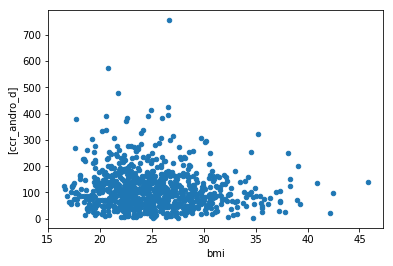

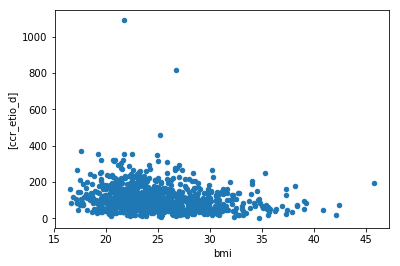

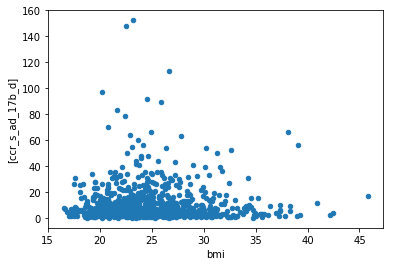

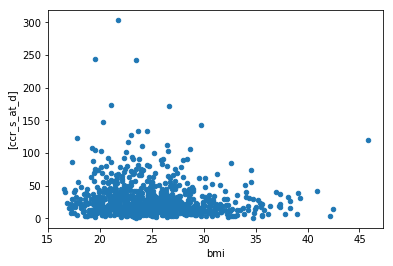

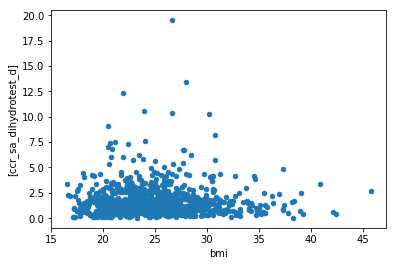

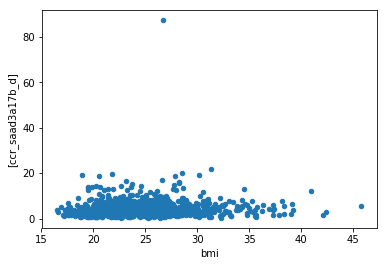

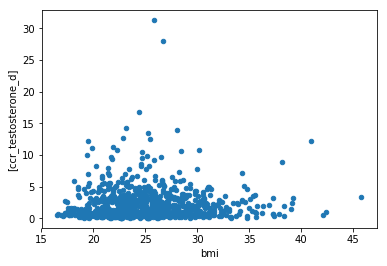

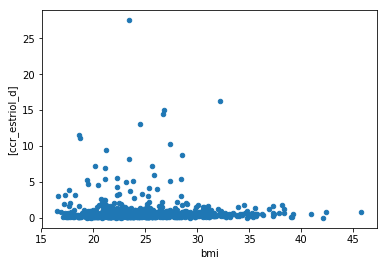

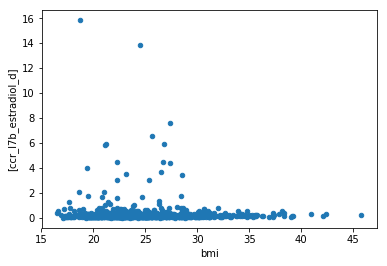

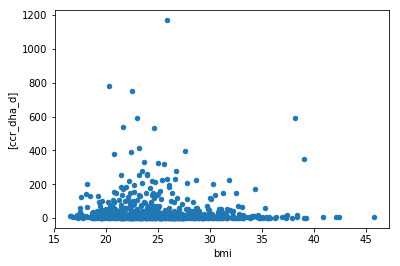

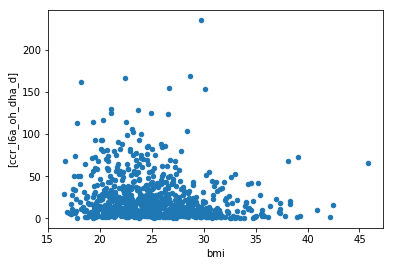

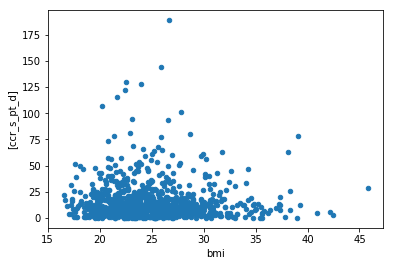

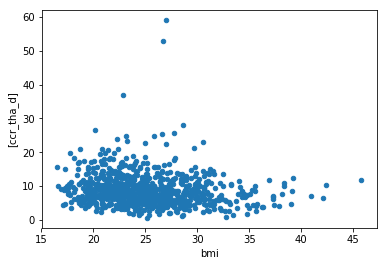

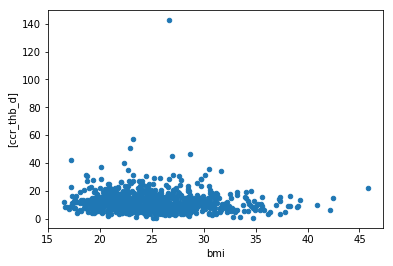

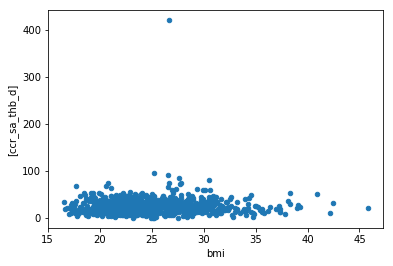

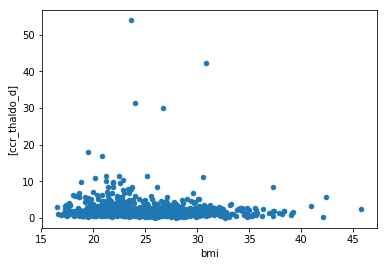

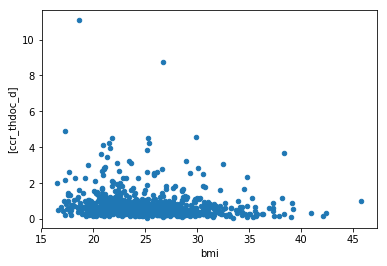

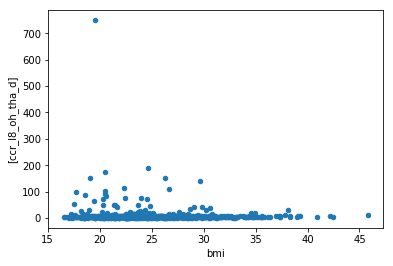

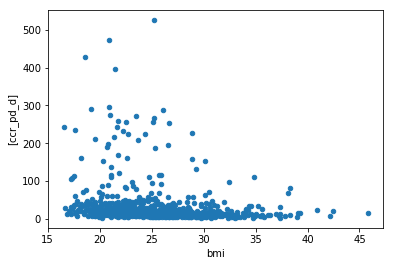

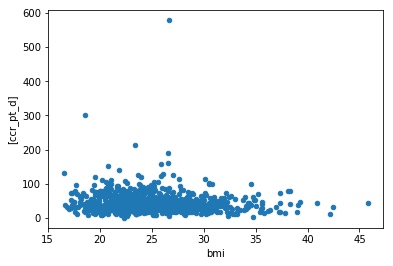

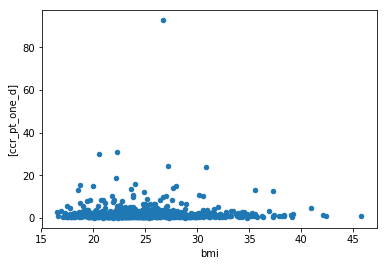

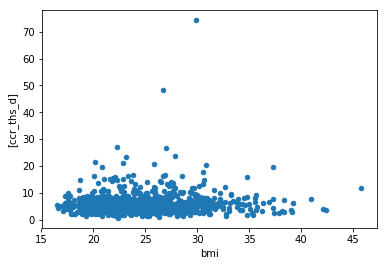

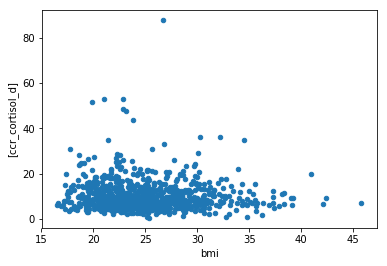

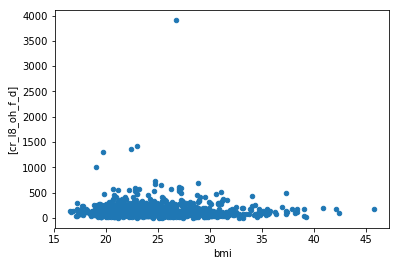

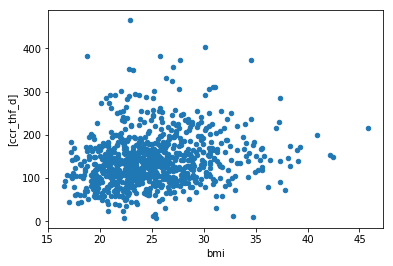

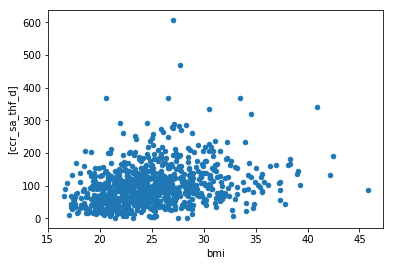

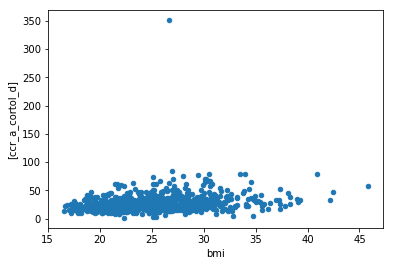

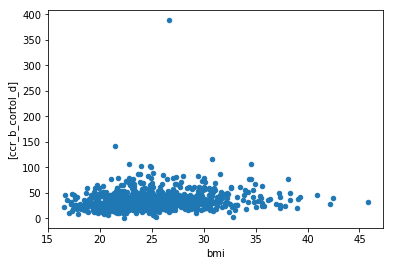

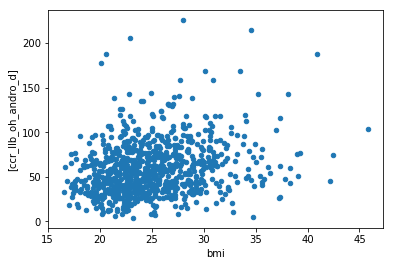

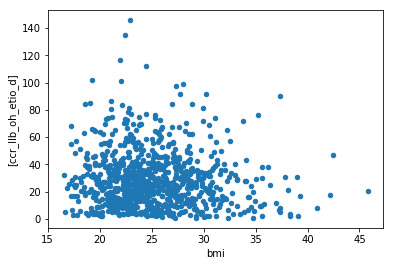

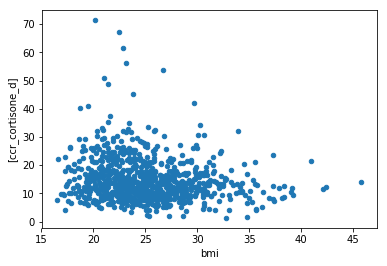

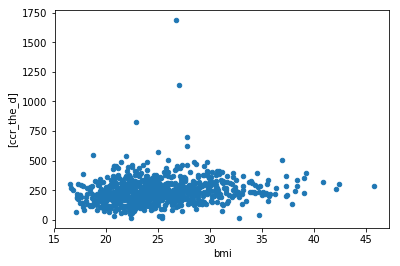

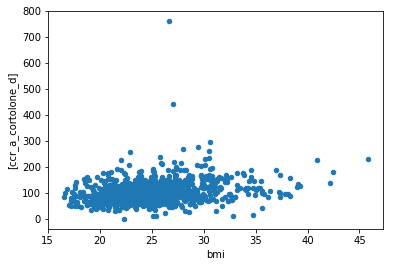

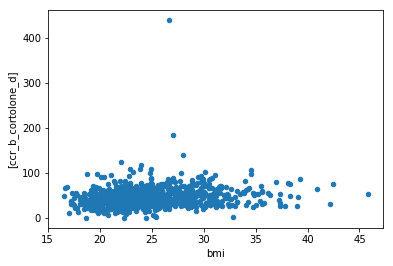

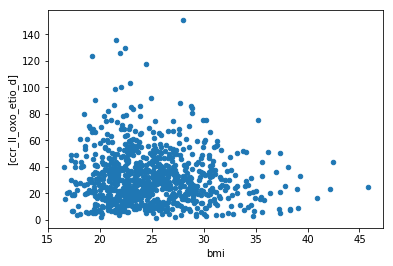

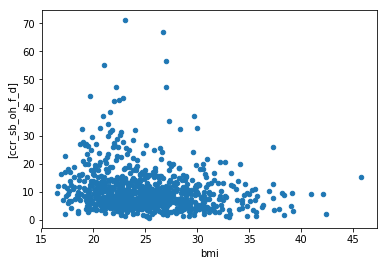

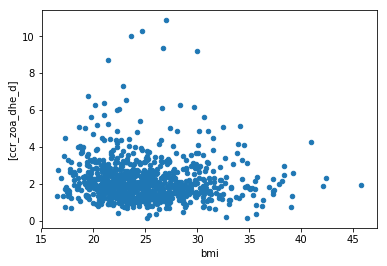

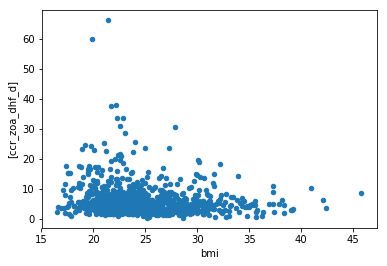

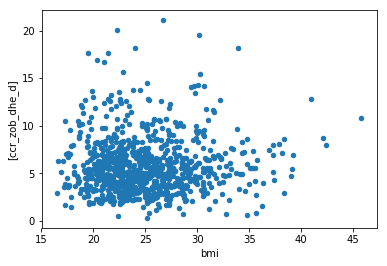

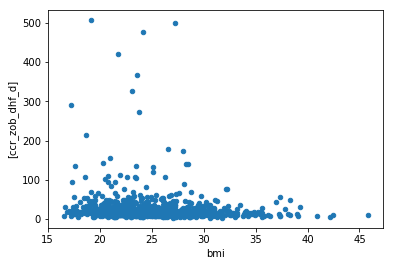

In [11]:
'''x = df_imputed['bmi']
y = df_imputed['ccr_andro_d']

plt.scatter(x,y,s=5)
plt.title('ccr_andro_d')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('ScatterPlot.png')
plt.show()'''

#df_imputed.plot.scatter(x='bmi', y='ccr_b_cortolone_d')


steroid_names = headers_steroid[1:-1]
print steroid_names

for ster in steroid_names:
    #print ster
    df_imputed.plot.scatter(x='bmi', y=[ster])

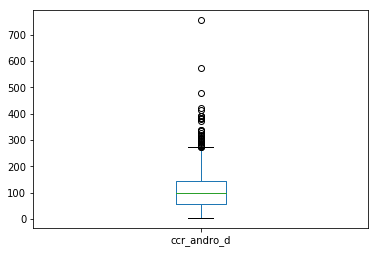

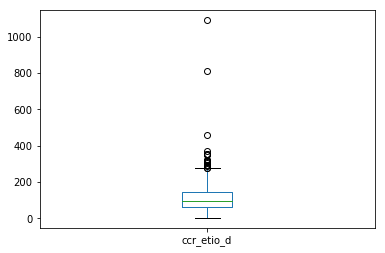

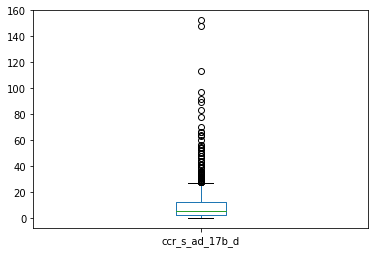

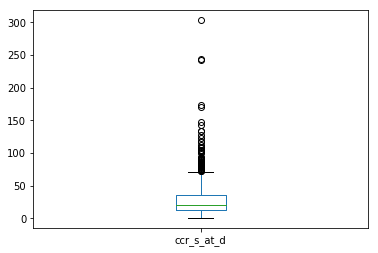

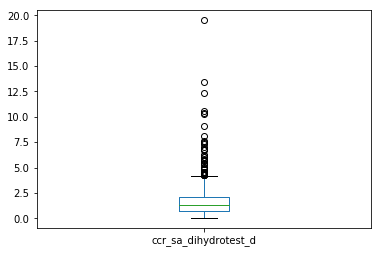

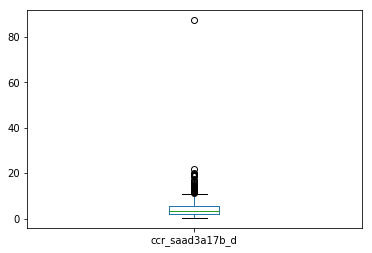

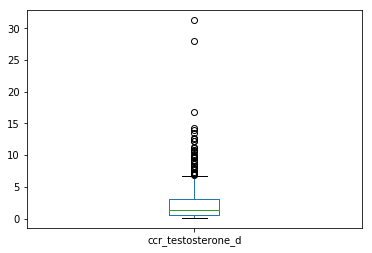

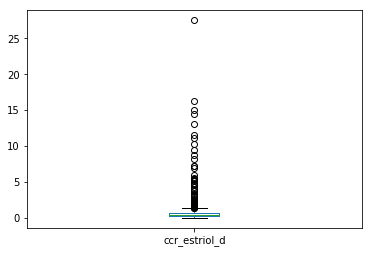

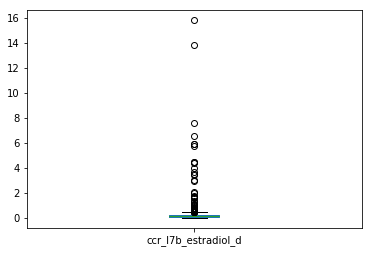

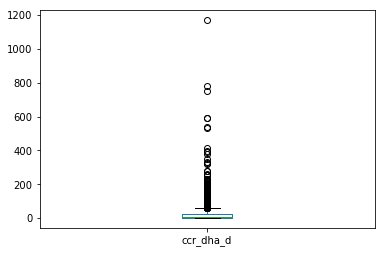

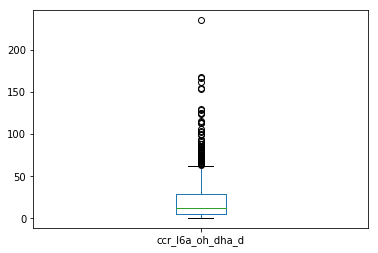

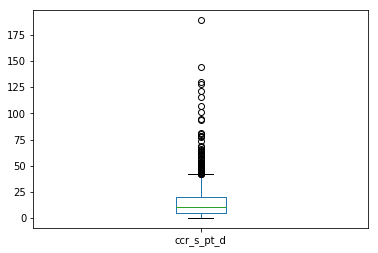

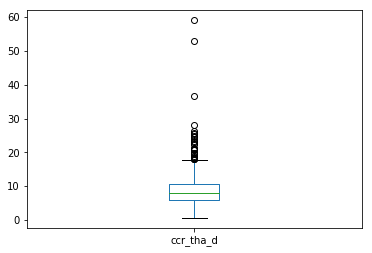

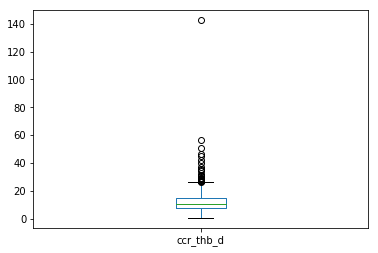

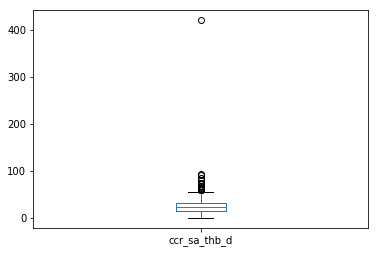

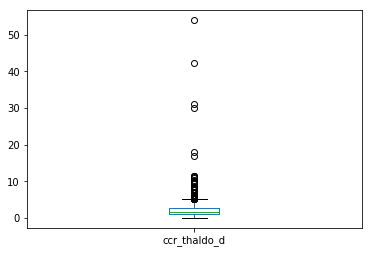

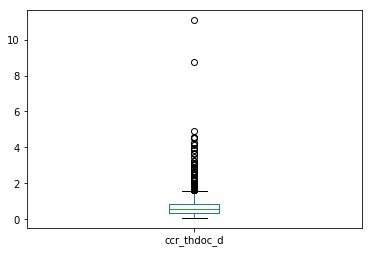

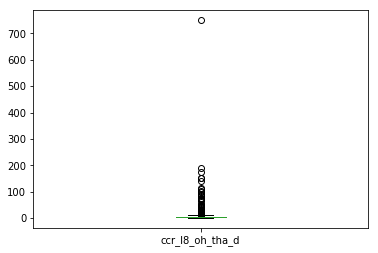

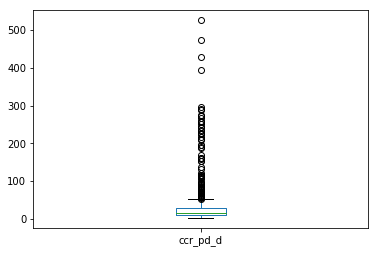

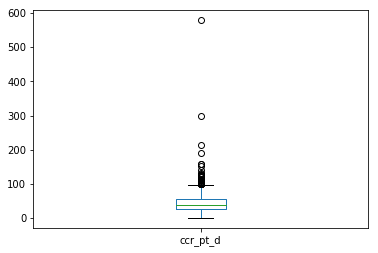

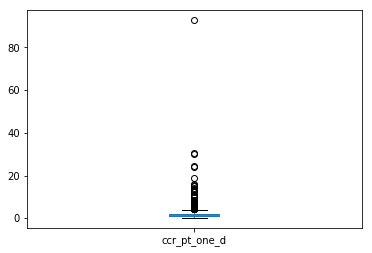

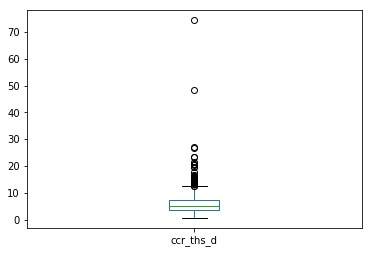

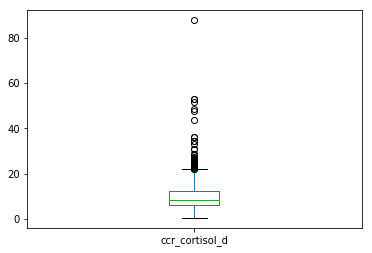

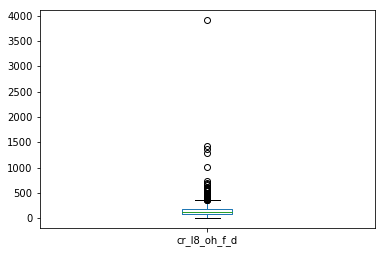

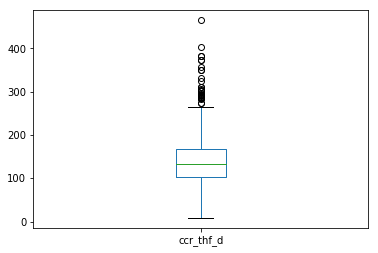

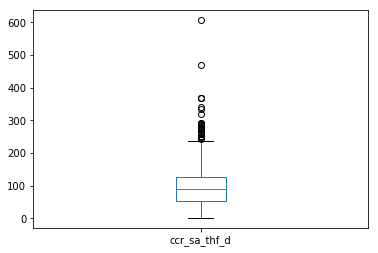

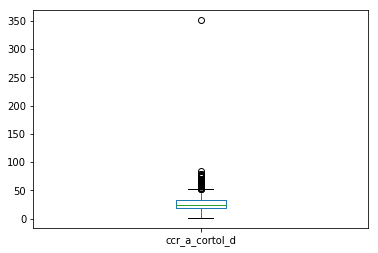

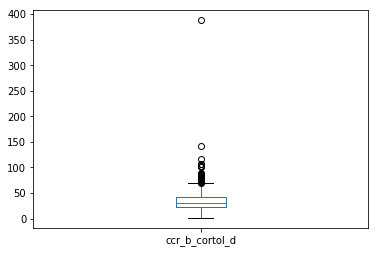

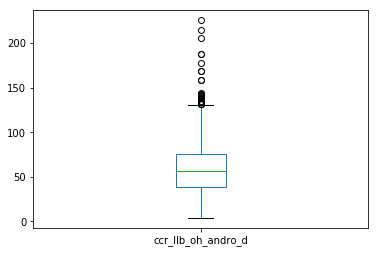

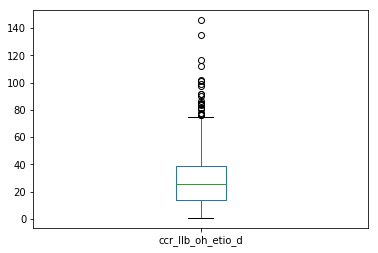

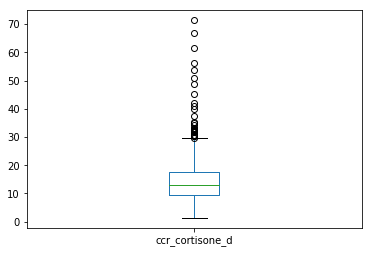

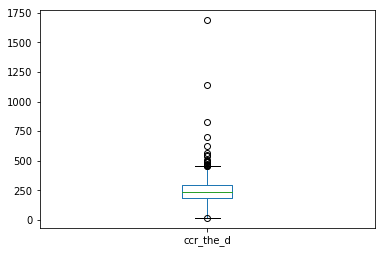

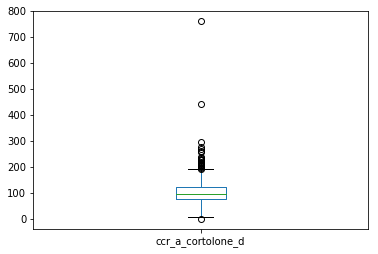

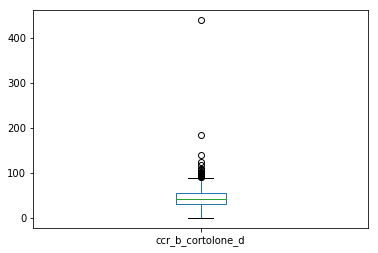

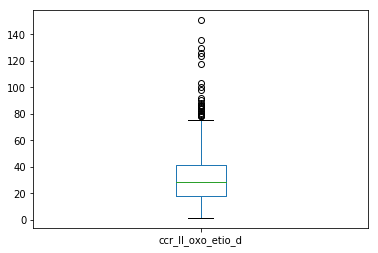

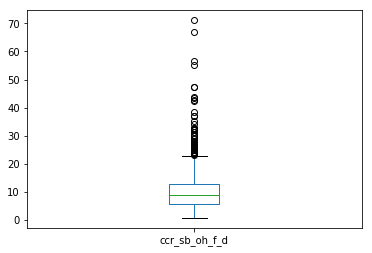

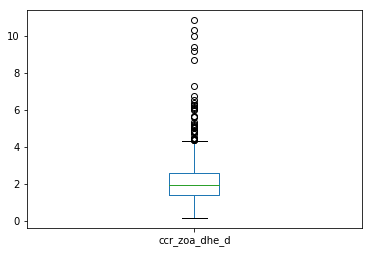

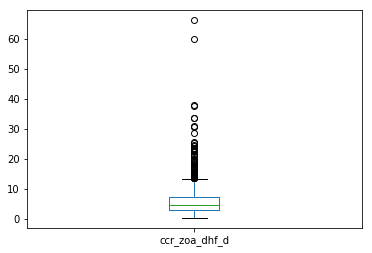

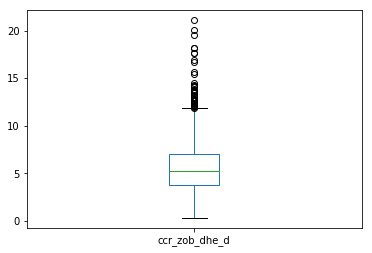

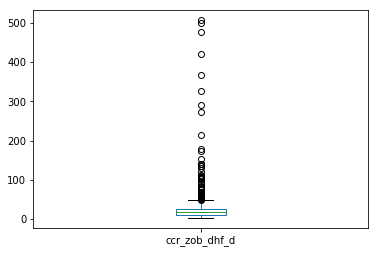

In [12]:
for ster in steroid_names:
    #print ster
    df_imputed.plot.box(y=[ster])

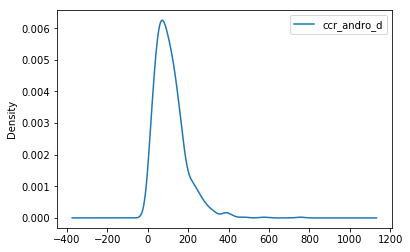

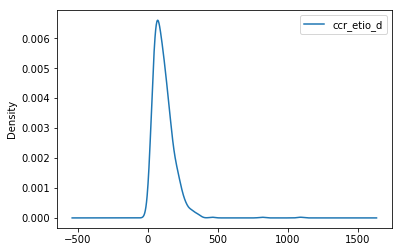

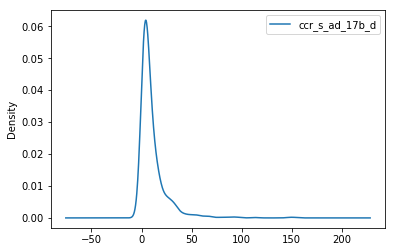

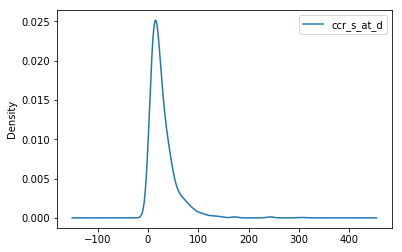

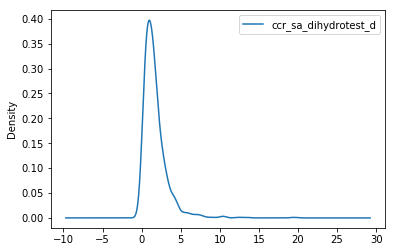

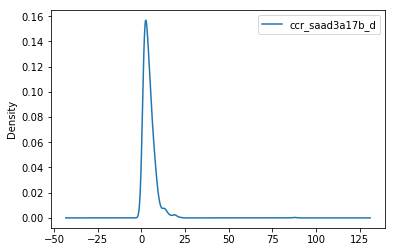

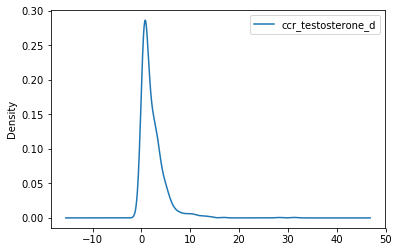

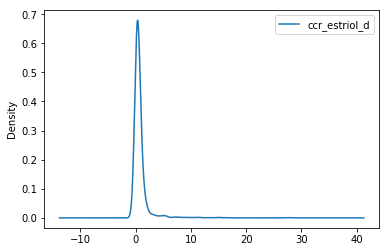

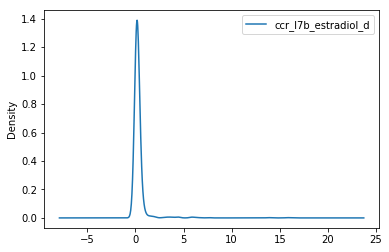

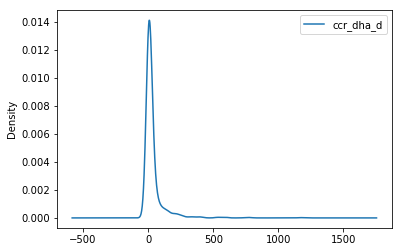

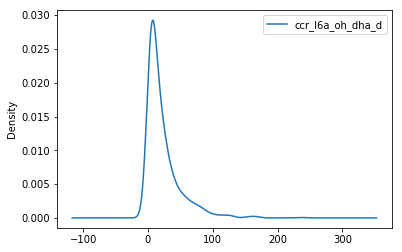

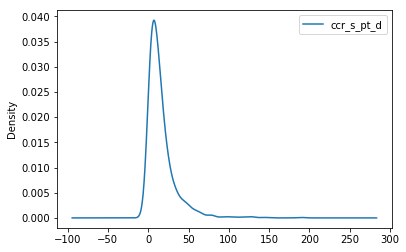

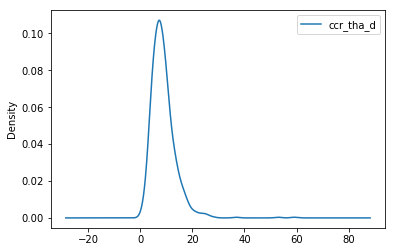

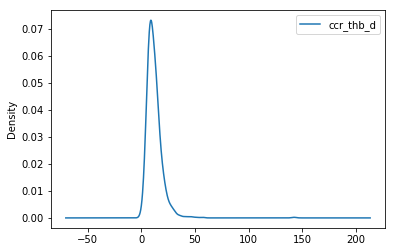

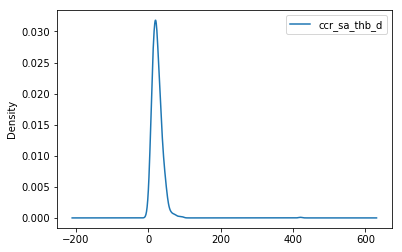

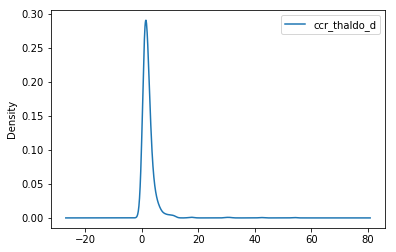

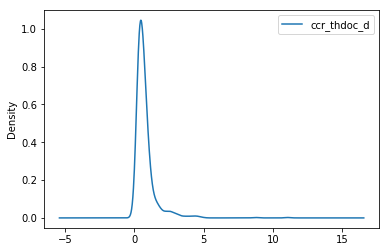

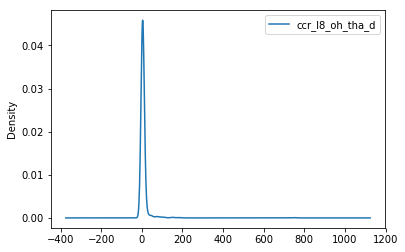

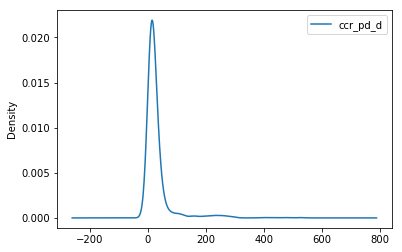

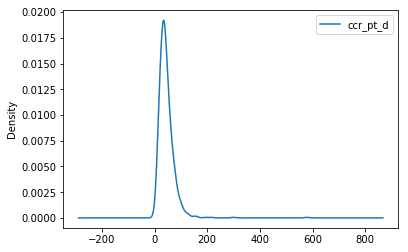

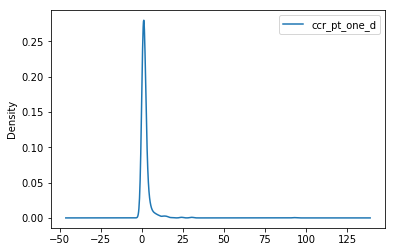

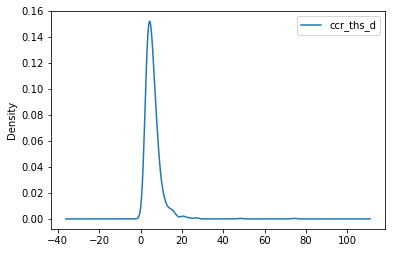

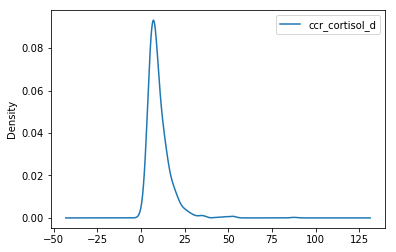

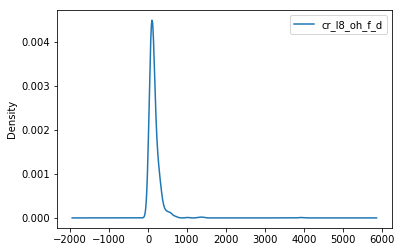

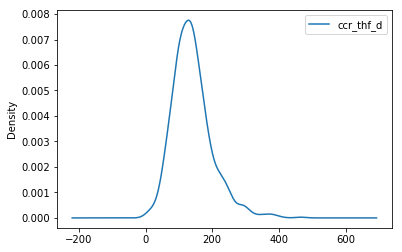

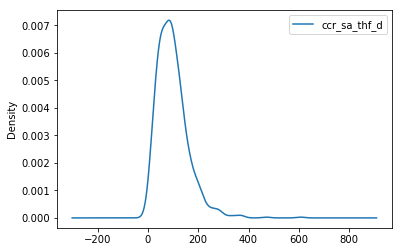

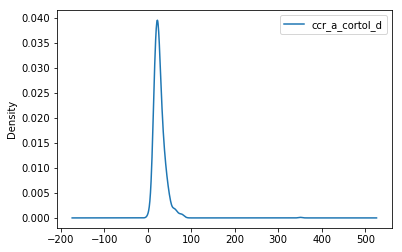

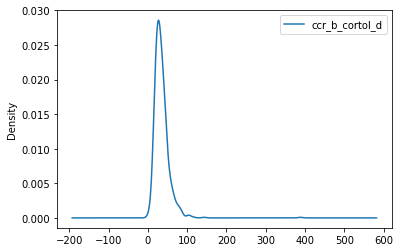

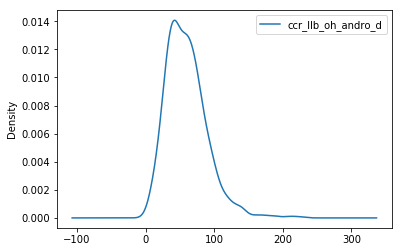

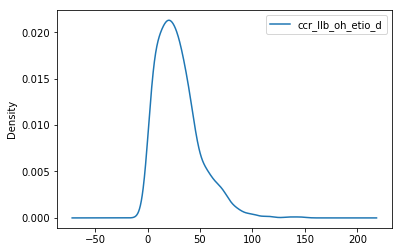

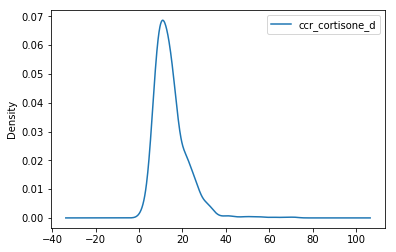

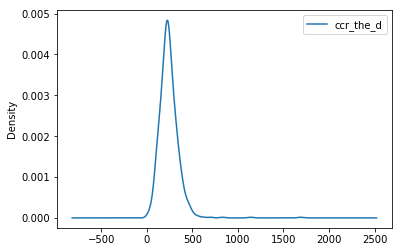

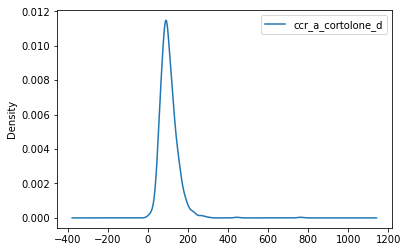

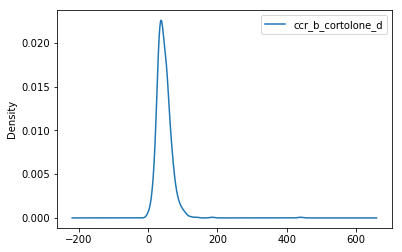

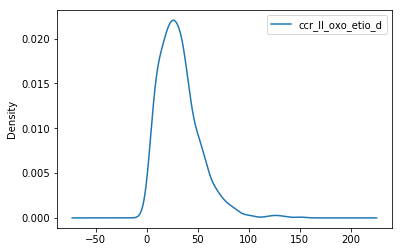

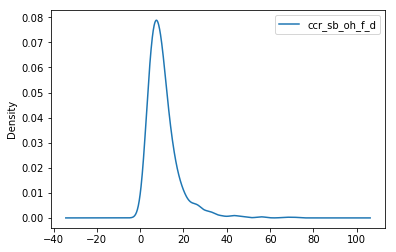

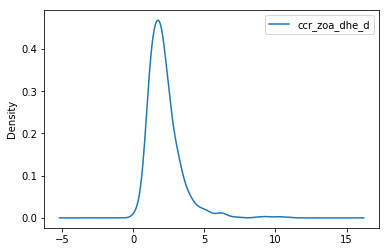

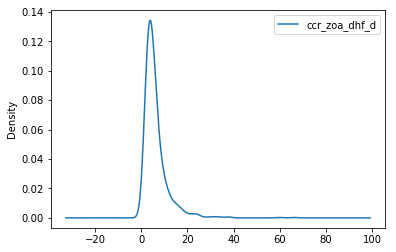

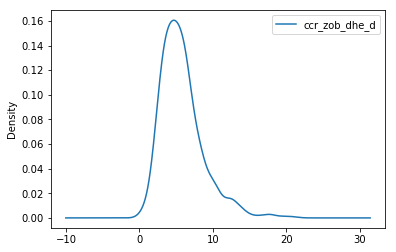

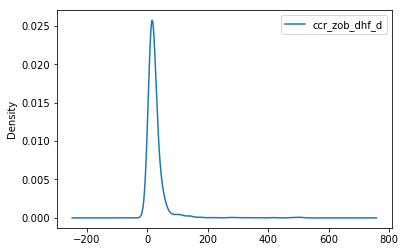

In [13]:
for ster in steroid_names:
    #print ster
    df_imputed.plot.kde(x='bmi', y=[ster])

In [14]:

df_perso = pd.DataFrame(records_matrix_personal, columns = headers_personal)
df_perso

# Remove patient that are not in df_imputed



,id,waistc1,bw,bia_fmkg,hipcirc1,armcicrc1_l,skinf2_1,bsa_dubois,bia_fmp,kid_vol,crap,ura,dbp5,sbp,cuff_sh,ud_mlkg,ckd_epi,sex,crp,bmi
0,2.0,87.0,73.400002,20.600000,100.0,30.500000,21.200001,1.822874,28.100000,116.440720,4.40,261.0,82.0,113.6,2.0,19.931880,92.294717,2.0,0.5,26.318621
1,5.0,96.0,82.199997,21.400000,102.5,31.000000,23.000000,1.982840,26.000000,120.467820,3.30,461.0,90.0,132.8,2.0,12.591241,71.842109,1.0,27.0,26.688094
2,6.0,86.5,86.400002,15.300000,107.5,29.000000,11.400000,2.104186,17.700001,231.705213,3.90,347.0,74.0,105.6,2.0,11.296296,100.816170,1.0,0.5,25.244705
3,8.0,80.5,69.400002,18.900000,96.5,26.000000,11.500000,1.748961,29.299999,102.078094,3.50,220.0,76.0,128.0,2.0,17.291066,88.391355,2.0,5.0,26.120668
4,9.0,81.0,70.400002,13.600000,96.0,29.000000,16.799999,1.806353,19.299999,90.813720,4.20,233.0,80.0,117.6,2.0,9.573863,116.482408,1.0,0.5,24.648997
5,10.0,82.0,52.000000,11.900000,91.0,23.000000,7.600000,1.547048,22.000000,83.935224,3.00,300.0,64.0,100.8,2.0,21.750000,71.239842,2.0,0.5,19.571681
6,13.0,80.0,63.200001,20.299999,102.0,27.000000,21.000000,1.703136,32.099998,100.919126,3.50,217.0,74.0,125.2,2.0,8.544304,78.322140,2.0,0.5,22.935114
7,14.0,81.0,64.699997,19.900000,100.0,28.500000,26.000000,1.727707,30.799999,66.076082,4.10,215.0,82.0,146.4,2.0,17.140650,100.796499,2.0,0.5,23.199110
8,15.0,94.5,85.500000,21.600000,103.5,27.500000,15.000000,2.049503,25.299999,126.905950,3.80,422.0,88.0,132.4,2.0,12.116959,95.748088,1.0,0.5,26.536107
9,16.0,90.0,69.699997,28.200001,109.0,26.000000,22.799999,1.732645,40.500000,113.564220,3.70,362.0,72.0,102.0,2.0,10.889527,95.773210,2.0,0.5,27.057190


In [15]:
df_imputed['id']

0         2.0
1         5.0
2         6.0
3         8.0
4         9.0
5        10.0
6        13.0
7        14.0
8        15.0
9        16.0
10       17.0
11       19.0
12       20.0
13       21.0
14       22.0
15       25.0
16       26.0
17       29.0
18       30.0
19       32.0
20       34.0
21       36.0
22       37.0
23       38.0
24       40.0
25       42.0
26       44.0
27       46.0
28       47.0
29       48.0
        ...  
835    1097.0
836    1098.0
837    1099.0
838    1100.0
839    1101.0
840    1102.0
841    1103.0
842    1104.0
843    1105.0
844    1106.0
845    1108.0
846    1109.0
847    1110.0
848    1111.0
849    1112.0
850    1113.0
851    1114.0
852    1115.0
853    1116.0
854    1117.0
855    1118.0
856    1119.0
857    1120.0
858    1121.0
859    1122.0
860    1124.0
861    1125.0
862    1126.0
863    1127.0
864    1128.0
Name: id, dtype: float64

In [16]:
del df_perso['bmi']
df_all = pd.merge(df_perso, df_imputed, how='right', on=['id'])



In [17]:
for col in df_all:
    print col


id
waistc1
bw
bia_fmkg
hipcirc1
armcicrc1_l
skinf2_1
bsa_dubois
bia_fmp
kid_vol
crap
ura
dbp5
sbp
cuff_sh
ud_mlkg
ckd_epi
sex
crp
ccr_andro_d
ccr_etio_d
ccr_s_ad_17b_d
ccr_s_at_d
ccr_sa_dihydrotest_d
ccr_saad3a17b_d
ccr_testosterone_d
ccr_estriol_d
ccr_l7b_estradiol_d
ccr_dha_d
ccr_l6a_oh_dha_d
ccr_s_pt_d
ccr_tha_d
ccr_thb_d
ccr_sa_thb_d
ccr_thaldo_d
ccr_thdoc_d
ccr_l8_oh_tha_d
ccr_pd_d
ccr_pt_d
ccr_pt_one_d
ccr_ths_d
ccr_cortisol_d
cr_l8_oh_f_d
ccr_thf_d
ccr_sa_thf_d
ccr_a_cortol_d
ccr_b_cortol_d
ccr_llb_oh_andro_d
ccr_llb_oh_etio_d
ccr_cortisone_d
ccr_the_d
ccr_a_cortolone_d
ccr_b_cortolone_d
ccr_ll_oxo_etio_d
ccr_sb_oh_f_d
ccr_zoa_dhe_d
ccr_zoa_dhf_d
ccr_zob_dhe_d
ccr_zob_dhf_d
bmi


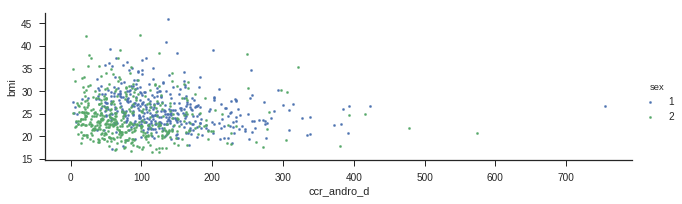

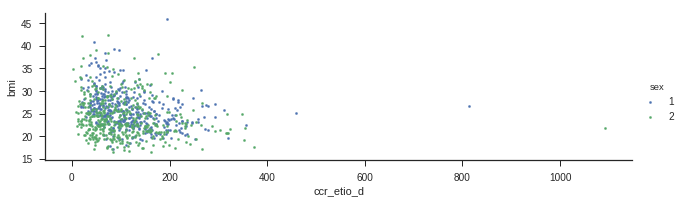

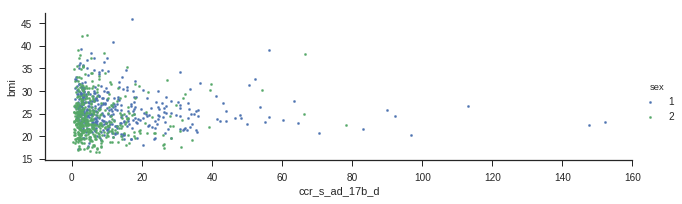

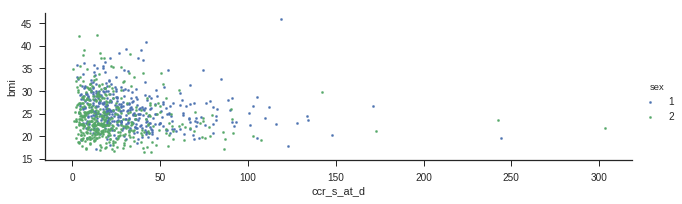

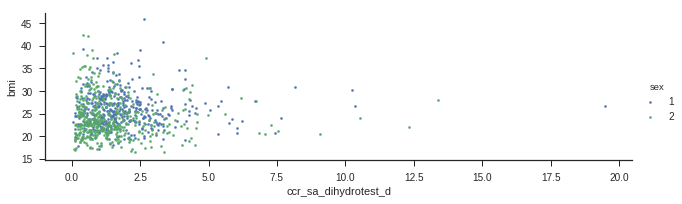

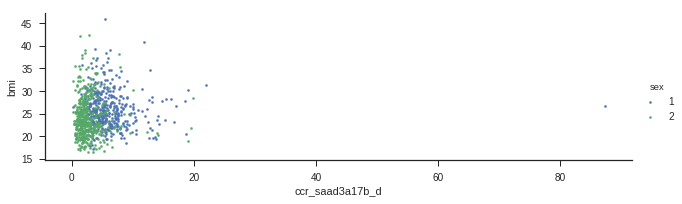

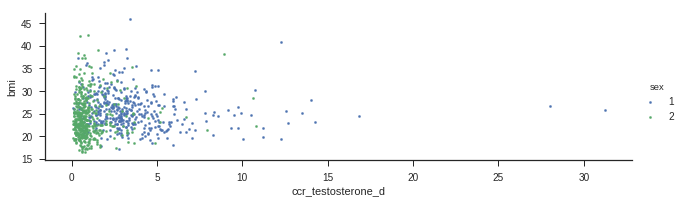

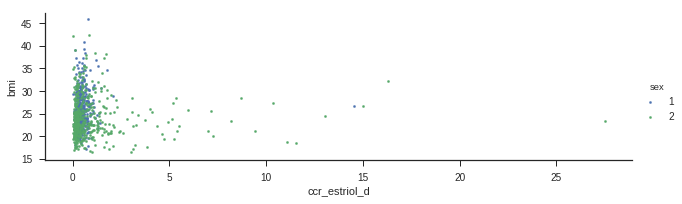

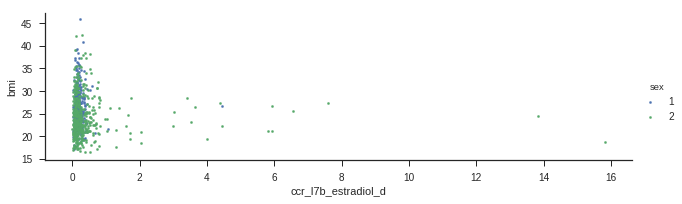

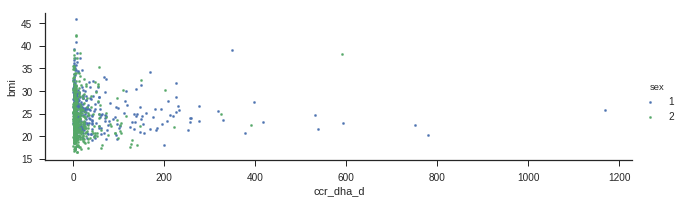

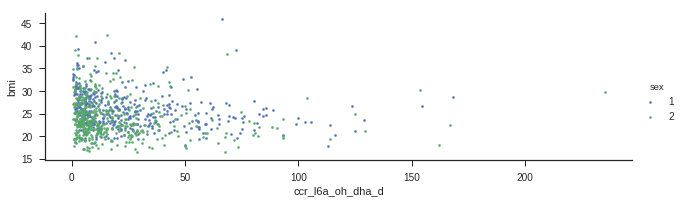

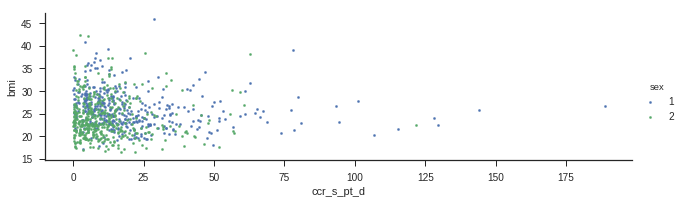

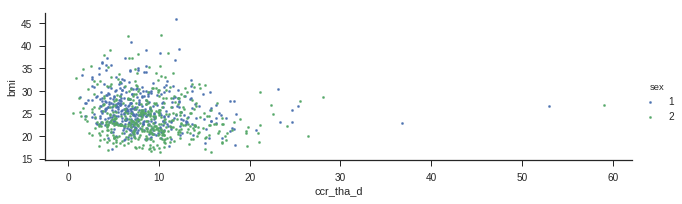

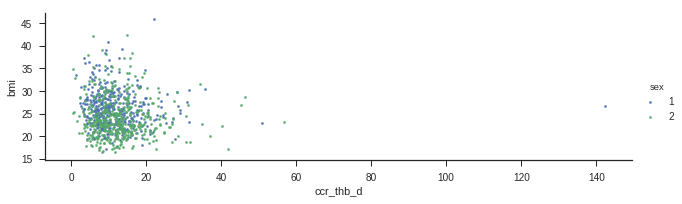

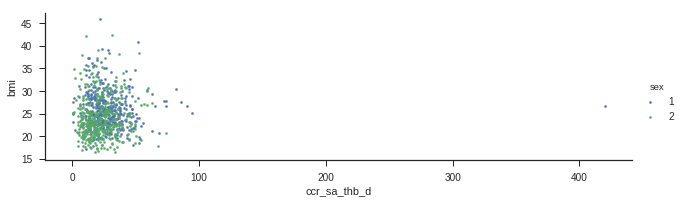

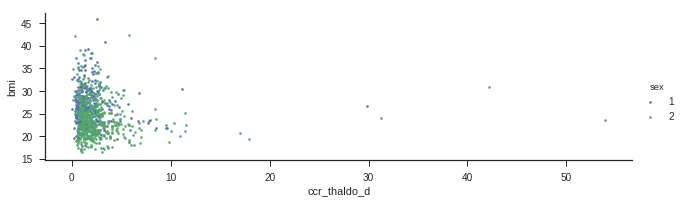

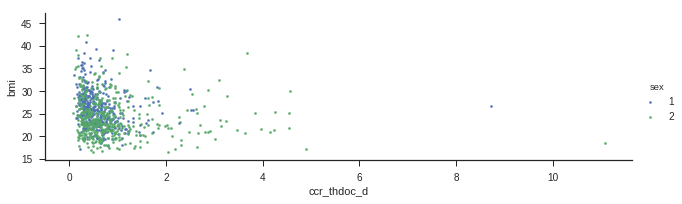

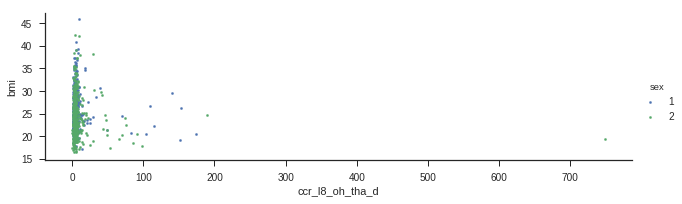

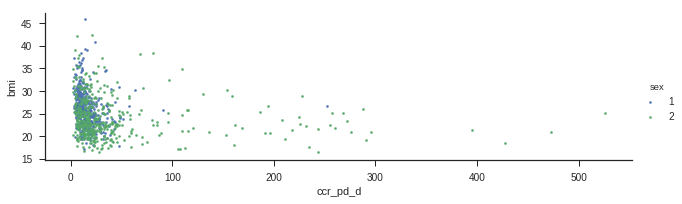

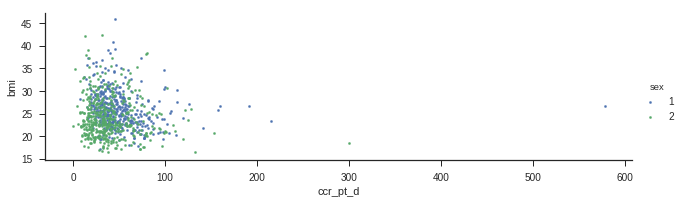

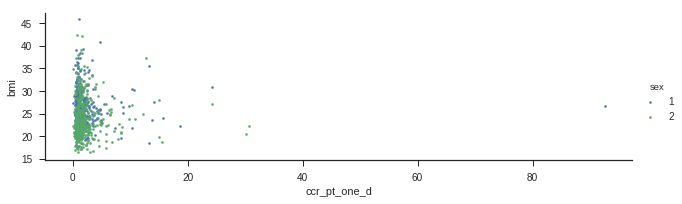

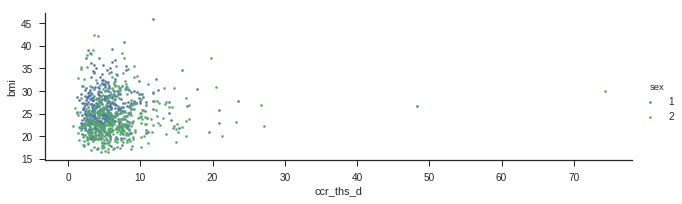

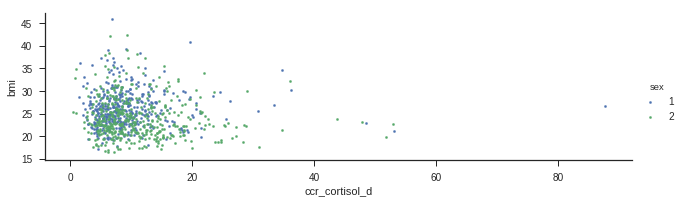

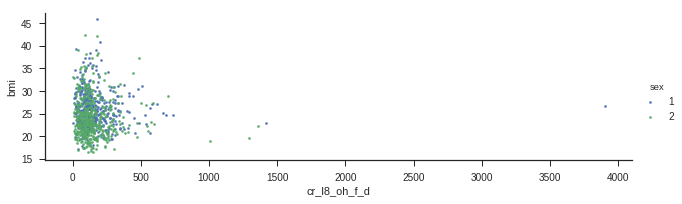

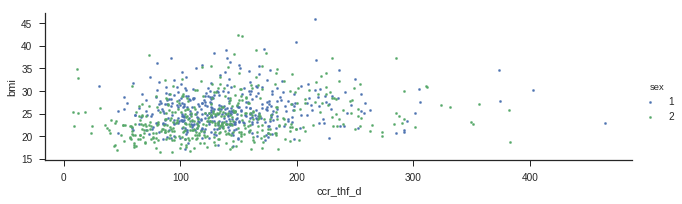

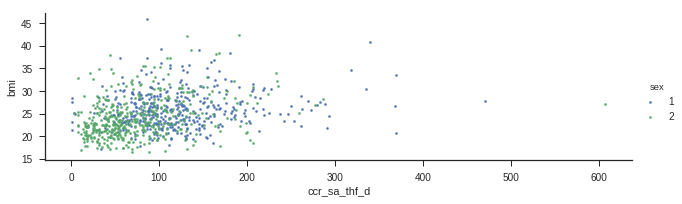

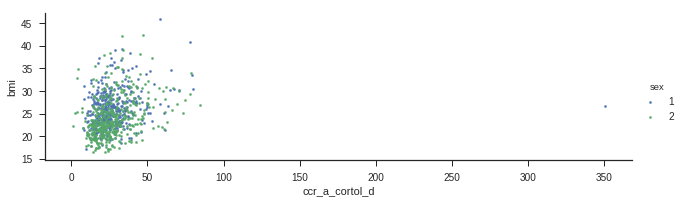

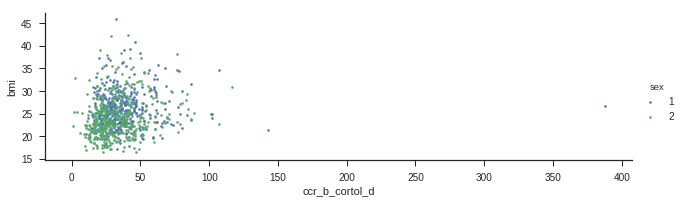

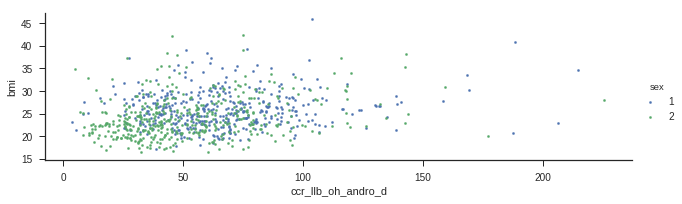

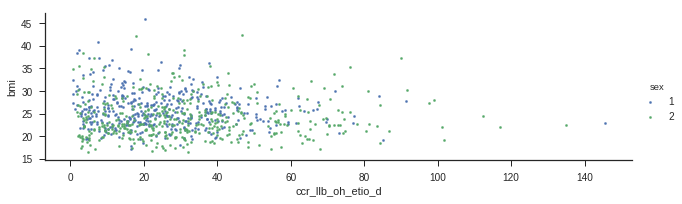

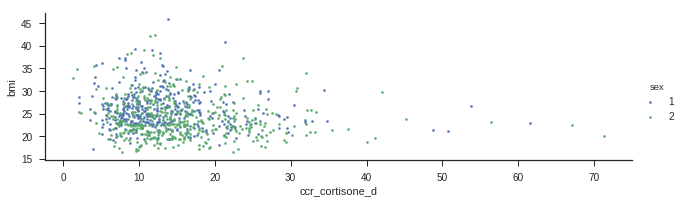

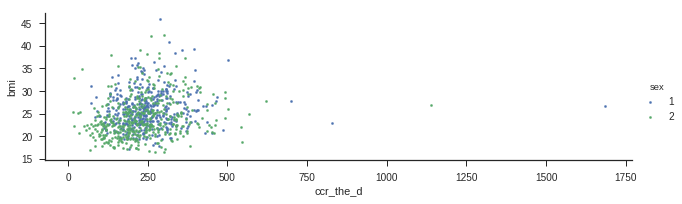

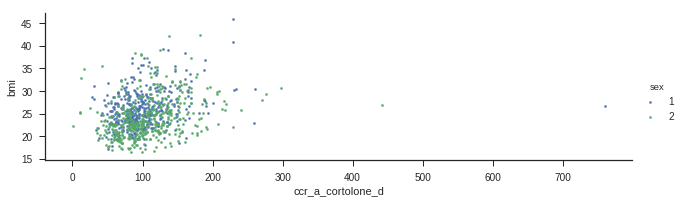

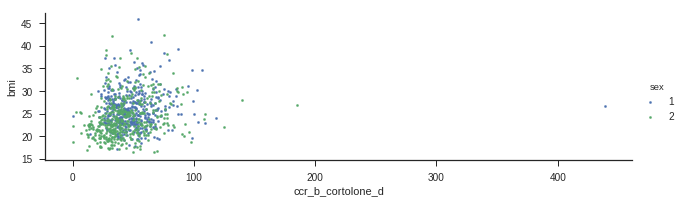

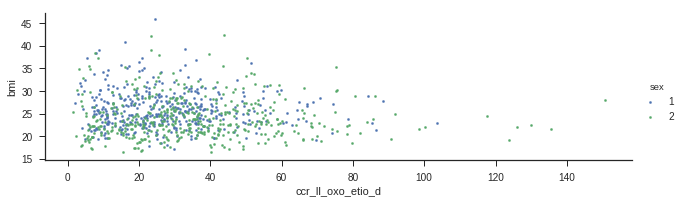

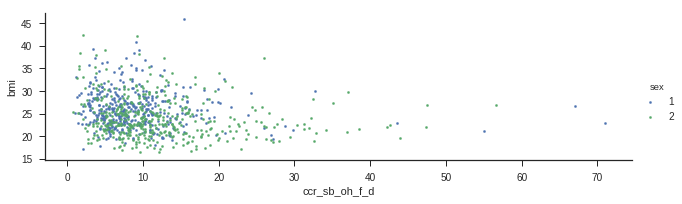

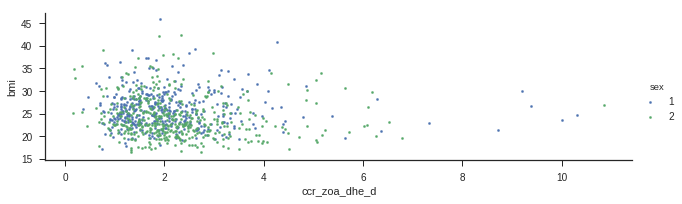

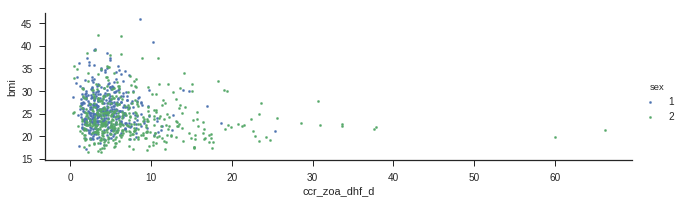

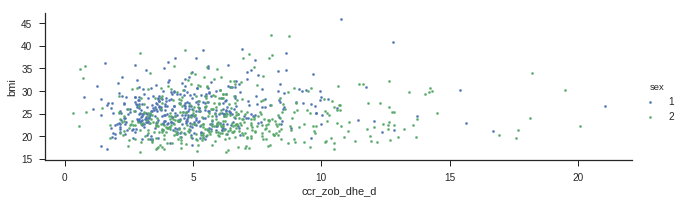

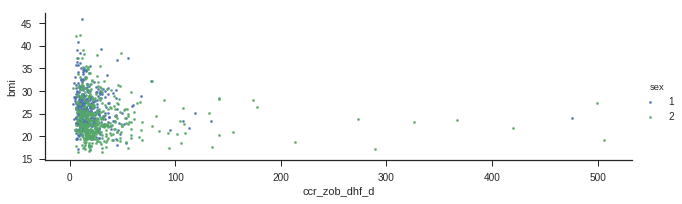

In [18]:
# ploting df_all
from  matplotlib import pyplot
import seaborn
seaborn.set(style='ticks')


#df_all.plot(x='sex', y='bmi_y', style=['o','rx'])

for ster in steroid_names:
    df_interm = pd.concat([df_all[ster], df_all['bmi'], df_all['sex']], axis=1, keys=[ster, 'bmi', 'sex'])
    
    _genders = [1,2]
    
    fg = seaborn.FacetGrid(data=df_interm, hue='sex', hue_order=_genders, aspect=3)
    fg.map(pyplot.scatter, ster, 'bmi',s=5).add_legend()

# Export en CSV

## df_imputed

Contient les stéroïdes et le BMI, aucune autre information sur les patients


## df_all 

Contient toutes les informations y compris le sex, pression systolique, etc

In [21]:
df_imputed.to_csv("df_imputed.csv", sep=',', encoding='utf-8')

In [22]:
df_all.to_csv("df_all.csv", sep=',', encoding='utf-8')